In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
df = pd.read_csv('./data/superstore.csv')
df.head()

,Category,City,Country,Customer.ID,Customer.Name,Discount,Market,记录数,Order.Date,Order.ID,...,Sales,Segment,Ship.Date,Ship.Mode,Shipping.Cost,State,Sub.Category,Year,Market2,weeknum
0,Office Supplies,Los Angeles,United States,LS-172304,Lycoris Saunders,0.0,US,1,2011-01-07 00:00:00.000,CA-2011-130813,...,19,Consumer,2011-01-09 00:00:00.000,Second Class,4.37,California,Paper,2011,North America,2
1,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,2011-01-21 00:00:00.000,CA-2011-148614,...,19,Consumer,2011-01-26 00:00:00.000,Standard Class,0.94,California,Paper,2011,North America,4
2,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05 00:00:00.000,CA-2011-118962,...,21,Consumer,2011-08-09 00:00:00.000,Standard Class,1.81,California,Paper,2011,North America,32
3,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05 00:00:00.000,CA-2011-118962,...,111,Consumer,2011-08-09 00:00:00.000,Standard Class,4.59,California,Paper,2011,North America,32
4,Office Supplies,Los Angeles,United States,AP-109154,Arthur Prichep,0.0,US,1,2011-09-29 00:00:00.000,CA-2011-146969,...,6,Consumer,2011-10-03 00:00:00.000,Standard Class,1.32,California,Paper,2011,North America,40


In [4]:
df.columns

Index(['Category', 'City', 'Country', 'Customer.ID', 'Customer.Name',
       'Discount', 'Market', '记录数', 'Order.Date', 'Order.ID', 'Order.Priority',
       'Product.ID', 'Product.Name', 'Profit', 'Quantity', 'Region', 'Row.ID',
       'Sales', 'Segment', 'Ship.Date', 'Ship.Mode', 'Shipping.Cost', 'State',
       'Sub.Category', 'Year', 'Market2', 'weeknum'],
      dtype='object')

In [5]:
print(df.shape)

(51290, 27)


In [6]:
df[['Sales', 'Profit', 'Quantity']].sum()

Sales       1.264290e+07
Profit      1.467457e+06
Quantity    1.783120e+05
dtype: float64

In [7]:
df.dtypes

Category           object
City               object
Country            object
Customer.ID        object
Customer.Name      object
Discount          float64
Market             object
记录数                 int64
Order.Date         object
Order.ID           object
Order.Priority     object
Product.ID         object
Product.Name       object
Profit            float64
Quantity            int64
Region             object
Row.ID              int64
Sales               int64
Segment            object
Ship.Date          object
Ship.Mode          object
Shipping.Cost     float64
State              object
Sub.Category       object
Year                int64
Market2            object
weeknum             int64
dtype: object

In [8]:
df['Order.Date'] = pd.to_datetime(df['Order.Date'])
df['Ship.Date'] = pd.to_datetime(df['Ship.Date'])

In [9]:
df.nunique()[['Product.ID','Customer.ID','Country']]

Product.ID     10292
Customer.ID     4873
Country          147
dtype: int64

In [10]:
df.groupby('Category')['Sales'].sum().sort_values(ascending=False).head()

Category
Technology         4744691
Furniture          4110884
Office Supplies    3787330
Name: Sales, dtype: int64

In [11]:
(df['Segment'].value_counts(normalize=True) * 100)

Segment
Consumer       51.702086
Corporate      30.081887
Home Office    18.216027
Name: proportion, dtype: float64

In [12]:
df['State'].value_counts().head(10)

State
California                2001
England                   1499
New York                  1128
Texas                      985
Ile-de-France              981
New South Wales            781
North Rhine-Westphalia     719
Queensland                 717
San Salvador               615
Pennsylvania               587
Name: count, dtype: int64

In [13]:
df['Discount'].mean()

np.float64(0.14290754533047376)

In [14]:
df[['Sales','Profit','Quantity','Discount']].corr()

,Sales,Profit,Quantity,Discount
Sales,1.000000,0.484923,0.313580,-0.086728
Profit,0.484923,1.000000,0.104365,-0.316490
Quantity,0.313580,0.104365,1.000000,-0.019875
Discount,-0.086728,-0.316490,-0.019875,1.000000


In [15]:
df['Ship.Mode'].value_counts()

Ship.Mode
Standard Class    30775
Second Class      10309
First Class        7505
Same Day           2701
Name: count, dtype: int64

In [16]:
df['Order.Date'].min(), df['Order.Date'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2014-12-31 00:00:00'))

In [17]:
df['Shipping.Cost'].mean()

np.float64(26.3758179645155)

In [18]:
df['Year'].value_counts()

Year
2014    17531
2013    13799
2012    10962
2011     8998
Name: count, dtype: int64

In [19]:
df.groupby('Sub.Category')['Profit'].sum().sort_values(ascending=False).head()

Sub.Category
Copiers       258567.54818
Phones        216717.00580
Bookcases     161924.41950
Appliances    141680.58940
Chairs        140396.26750
Name: Profit, dtype: float64

In [20]:
(df['Profit'] < 0).sum()

np.int64(12544)

In [21]:
yoy = df.groupby('Year')[['Sales','Profit']].sum().pct_change()*100
yoy

,Sales,Profit
Year,,
2011,NaN,NaN
2012,18.498781,23.489305
2013,27.203320,32.373131
2014,26.254191,23.893419


In [22]:
df['Month'] = df['Order.Date'].dt.month
monthly = df.groupby('Month')['Sales'].sum()
monthly

Month
1      675141
2      543768
3      770519
4      698603
5      904061
6     1269751
7      749423
8     1293852
9     1437432
10    1168220
11    1551319
12    1580816
Name: Sales, dtype: int64

In [23]:
df['Ship.Delay'] = (df['Ship.Date'] - df['Order.Date']).dt.days
df['Ship.Delay'].describe()

count    51290.000000
mean         3.969370
std          1.729437
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: Ship.Delay, dtype: float64

In [24]:
df['Profit.Margin'] = df['Profit'] / df['Sales']
df.groupby('Market')['Profit.Margin'].mean().sort_values()

Market
US            -inf
Africa   -0.145092
EMEA     -0.141618
LATAM     0.061712
APAC      0.069545
EU        0.110167
Canada    0.247431
Name: Profit.Margin, dtype: float64

In [25]:
df.groupby('Customer.ID')['Profit'].sum().sort_values(ascending=False).head(10)

Customer.ID
TC-209804    8981.3239
RB-193604    6976.0959
SC-200954    5757.4119
HL-150404    5622.4292
AB-101054    5444.8055
SP-209202    4974.5130
TA-213854    4703.7883
CA-127751    4045.8780
PJ-188352    3986.0040
CM-123854    3899.8904
Name: Profit, dtype: float64

In [26]:
df.groupby('Product.Name')['Profit'].sum().sort_values().head(10)

Product.Name
Cubify CubeX 3D Printer Double Head Print                  -8879.9704
Lexmark MX611dhe Monochrome Laser Printer                  -4589.9730
Motorola Smart Phone, Cordless                             -4447.0380
Cubify CubeX 3D Printer Triple Head Print                  -3839.9904
Bevis Round Table, Adjustable Height                       -3649.8940
Bevis Computer Table, Fully Assembled                      -3509.5638
Rogers Lockers, Blue                                       -2893.4908
Chromcraft Bull-Nose Wood Oval Conference Tables & Bases   -2876.1156
Bevis Wood Table, with Bottom Storage                      -2782.5880
Lesro Training Table, Rectangular                          -2581.2834
Name: Profit, dtype: float64

In [27]:
df.groupby(pd.cut(df['Discount'], bins=[0,0.1,0.2,0.3,0.4,1]))['Profit'].mean()

C:\Users\srmpc\AppData\Local\Temp\ipykernel_18596\2538596018.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['Discount'], bins=[0,0.1,0.2,0.3,0.4,1]))['Profit'].mean()


Discount
(0.0, 0.1]    72.278107
(0.1, 0.2]    27.614734
(0.2, 0.3]   -21.877573
(0.3, 0.4]   -48.857485
(0.4, 1.0]   -90.132312
Name: Profit, dtype: float64

In [28]:
df.groupby('Market')['Shipping.Cost'].mean().sort_values()

Market
EMEA      17.573221
Africa    19.215058
Canada    19.285495
LATAM     22.744668
US        23.831678
EU        30.942235
APAC      35.190430
Name: Shipping.Cost, dtype: float64

In [29]:
df['AOV'] = df['Sales']
df.groupby('Region')['AOV'].mean().sort_values(ascending=False)

Region
Central Asia      367.597168
North Asia        362.852438
Oceania           315.516777
Southeast Asia    282.658357
North             260.855172
Central           253.881353
South             240.927013
East              238.354635
West              226.510771
Caribbean         191.882249
Canada            174.302083
Africa            170.868978
EMEA              160.307019
Name: AOV, dtype: float64

In [30]:
df.groupby('weeknum')['Order.ID'].count()

weeknum
1      381
2      550
3      604
4      568
5      568
6      527
7      592
8      536
9      543
10     679
11     697
12     745
13     649
14     711
15     724
16     742
17     714
18     692
19     936
20     821
21     812
22     891
23    1153
24    1337
25    1228
26    1281
27     837
28     728
29     664
30     720
31     856
32    1147
33    1188
34    1166
35    1119
36    1358
37    1350
38    1453
39    1426
40    1118
41     940
42    1017
43    1046
44    1053
45    1508
46    1524
47    1527
48    1441
49    1440
50    1378
51    1381
52    1461
53     763
Name: Order.ID, dtype: int64

In [31]:
cat_yoy = df.groupby(['Year', 'Category'])['Profit'].sum().unstack()
cat_yoy

Category,Furniture,Office Supplies,Technology
Year,,,
2011,53696.9264,85996.5343,109247.35084
2012,58132.8340,103305.5078,145976.93730
2013,84062.9005,149245.7358,173626.59388
2014,89312.0629,179926.0564,234927.85116


In [32]:
df.groupby('Ship.Mode')['Shipping.Cost'].mean().sort_values()

Ship.Mode
Standard Class    19.971654
Second Class      30.469666
First Class       41.052970
Same Day          42.937325
Name: Shipping.Cost, dtype: float64

In [33]:
bins = [-1000,-100,-10,0,10,100,500,1000,5000]
pd.cut(df['Profit'], bins=bins).value_counts()

Profit
(10, 100]        19125
(0, 10]          13178
(-100, -10]       6230
(100, 500]        5098
(-10, 0]          4774
(-1000, -100]     2130
(500, 1000]        530
(1000, 5000]       144
Name: count, dtype: int64

In [34]:
df[['Shipping.Cost','Profit']].corr()

,Shipping.Cost,Profit
Shipping.Cost,1.000000,0.354441
Profit,0.354441,1.000000


In [35]:
df.groupby('Category')[['Profit','Sales']].sum().assign(
    Return_on_Sales=lambda x: x['Profit']/x['Sales']
).sort_values('Return_on_Sales', ascending=False)

,Profit,Sales,Return_on_Sales
Category,,,
Technology,663778.73318,4744691,0.139899
Office Supplies,518473.83430,3787330,0.136897
Furniture,285204.72380,4110884,0.069378


In [36]:
#Profit Predicting model
X = df[['Sales','Quantity','Discount','Shipping.Cost','Category','Sub.Category','Region']]
y = df['Profit']

cat_cols = ['Category','Sub.Category','Region']

pre = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocess', pre),
    ('reg',LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.13107524650612756

In [37]:
df.columns

Index(['Category', 'City', 'Country', 'Customer.ID', 'Customer.Name',
       'Discount', 'Market', '记录数', 'Order.Date', 'Order.ID', 'Order.Priority',
       'Product.ID', 'Product.Name', 'Profit', 'Quantity', 'Region', 'Row.ID',
       'Sales', 'Segment', 'Ship.Date', 'Ship.Mode', 'Shipping.Cost', 'State',
       'Sub.Category', 'Year', 'Market2', 'weeknum', 'Month', 'Ship.Delay',
       'Profit.Margin', 'AOV'],
      dtype='object')

In [38]:
weekly = df.groupby('weeknum')['Sales'].sum().sort_index()
weekly.rolling(window=4).mean()

weeknum
1           NaN
2           NaN
3           NaN
4     139844.25
5     150564.25
6     145623.75
7     142342.00
8     137857.50
9     136557.25
10    139976.25
11    149202.25
12    166784.25
13    176556.00
14    178549.00
15    176557.25
16    170259.50
17    165168.50
18    163645.00
19    173809.50
20    175346.50
21    185965.75
22    207902.00
23    224866.25
24    259436.25
25    283506.50
26    302024.25
27    283172.00
28    243855.75
29    208359.50
30    171789.25
31    179386.75
32    203621.25
33    240945.00
34    278232.50
35    290740.00
36    301918.25
37    311844.75
38    321811.75
39    334657.50
40    334584.25
41    309939.25
42    289941.25
43    269811.50
44    258575.75
45    291229.75
46    312659.75
47    343585.00
48    370738.75
49    359146.00
50    350584.50
51    350859.00
52    353928.75
53    316084.00
Name: Sales, dtype: float64

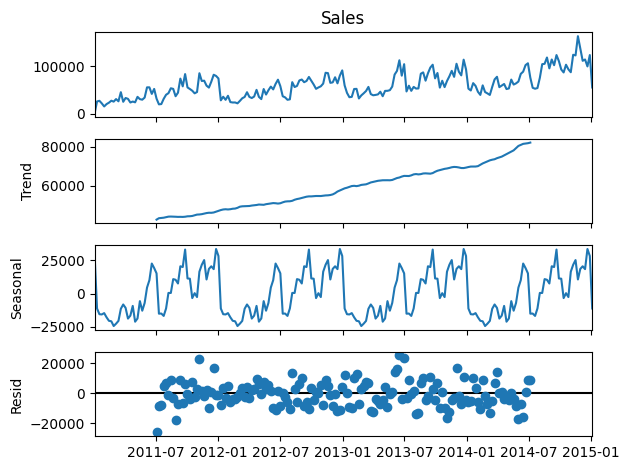

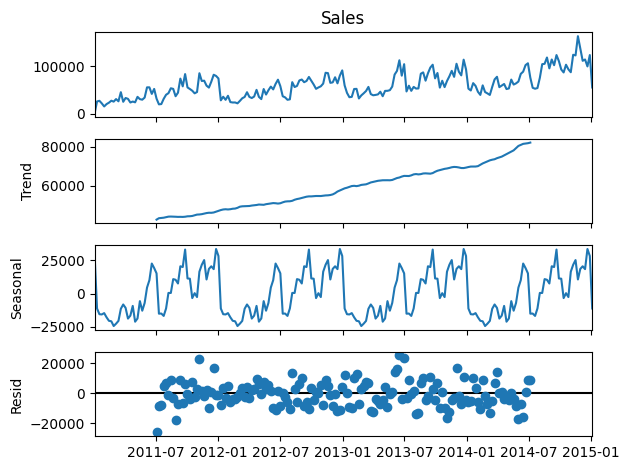

In [39]:
weekly = df.groupby('Order.Date')['Sales'].sum().resample('W').sum()
decomp = seasonal_decompose(weekly, model='additive')
decomp.plot()

In [40]:
snapshot_date = df['Order.Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer.ID').agg({
    'Order.Date': lambda x : (snapshot_date - x.max()).days,
    'Order.ID':'count',
    'Sales':'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.sort_values('Recency', ascending=False).head()

,Recency,Frequency,Monetary
Customer.ID,,,
MM-72602,1460,1,314
PG-88201,1443,2,459
DL-129252,1413,2,117
SN-105602,1413,4,441
CB-24151,1407,1,64


In [41]:
data = rfm[['Recency','Frequency','Monetary']]
scaled = StandardScaler().fit_transform(data)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled)
rfm.head()

c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", l

,Recency,Frequency,Monetary,Cluster
Customer.ID,,,,
AA-103151,9,10,1445,0
AA-103152,14,16,6105,2
AA-103153,695,5,633,1
AA-103154,185,11,5565,3
AA-103751,7,9,2407,0


In [42]:
Q1 = df['Shipping.Cost'].quantile(0.25)
Q3 = df['Shipping.Cost'].quantile(0.75)

IQR = Q3 - Q1
outliers = df[(df['Shipping.Cost'] < Q1 - 1.5*IQR) | (df['Shipping.Cost'] > Q3 + 1.5*IQR)]
outliers.shape

(5909, 31)

In [43]:
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly'] = iso.fit_predict(df[['Sales', 'Profit', 'Shipping.Cost']])
df['anomaly'].value_counts()

anomaly
 1    50264
-1     1026
Name: count, dtype: int64

In [44]:
df[['Discount', 'Quantity']].corr()

,Discount,Quantity
Discount,1.000000,-0.019875
Quantity,-0.019875,1.000000


In [45]:
df['Loss'] = (df['Profit'] < 0).astype(int)
X = df[['Sales', 'Quantity','Discount','Shipping.Cost']]
y = df['Loss']

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X, y)
tree.feature_importances_

array([4.13515907e-03, 0.00000000e+00, 9.95429564e-01, 4.35277151e-04])

In [46]:
reorders = df.groupby('Product.ID')['Order.ID'].nunique().sort_values(ascending=False)
reorders.head()

Product.ID
OFF-AR-10003651    35
OFF-AR-10003829    31
OFF-BI-10003708    30
OFF-BI-10002799    29
FUR-CH-10003354    28
Name: Order.ID, dtype: int64

In [47]:
weekly_profit = df.groupby('Order.Date')['Profit'].sum().resample('W').sum()

model = ARIMA(weekly_profit, order=(1,1,1))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Profit   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1989.183
Date:                Sat, 22 Nov 2025   AIC                           3984.367
Time:                        09:39:16   BIC                           3994.394
Sample:                    01-02-2011   HQIC                          3988.421
                         - 01-04-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0790      0.078      1.014      0.310      -0.074       0.232
ma.L1         -0.8262      0.048    -17.159      0.000      -0.921      -0.732
sigma2      1.149e+07    1.1e+06     10.486      0.000    9.34e+06    1.36e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.95
Prob(Q):                              0.86   Prob(JB):                         0.23
Heteroskedasticity (H):               2.57   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
df['Delay.Flag'] = (df['Ship.Delay'] > df['Ship.Delay'].median()).astype(int)

X = df[['Shipping.Cost','Discount','Quantity','Sales']]
y = df['Delay.Flag']

rf = RandomForestClassifier()
rf.fit(X, y)
rf.feature_importances_

array([0.50612367, 0.08354279, 0.09611257, 0.31422097])

In [49]:
df['CohortMonth'] = df['Order.Date'].dt.to_period

cohort = df.groupby(['CohortMonth', 'Customer.ID'])['Profit'].sum().unstack().mean(axis=1)
cohort

CohortMonth
<bound method PandasDelegate._add_delegate_accessors.<locals>._create_delegator_method.<locals>.f of <pandas.core.indexes.accessors.DatetimeProperties object at 0x000001CD62818770>>    301.140425
dtype: float64

In [50]:
pivote = df.pivot_table(values='Profit', index='Category', columns='Region', aggfunc='sum')
pivote

Region,Africa,Canada,Caribbean,Central,Central Asia,EMEA,East,North,North Asia,Oceania,South,Southeast Asia,West
Category,,,,,,,,,,,,,
Furniture,16262.085,2613.24,6223.46000,54550.84010,48935.712,11534.136,3046.1658,30922.06800,52181.301,32048.904,22651.62810,-7269.7665,11504.9503
Office Supplies,28480.053,7957.53,14818.27600,121314.72090,27104.500,14869.392,41014.5791,64403.39300,40926.105,33306.186,67495.99880,4173.2515,52609.8490
Technology,44129.493,7246.62,13529.58504,135538.42064,56439.975,17494.443,47462.0351,99272.49152,72471.015,54734.022,50208.13928,20948.8440,44303.6496


##

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
51285    2014
51286    2014
51287    2014
51288    2014
51289    2014
Name: Year, Length: 51290, dtype: int64

Visualization

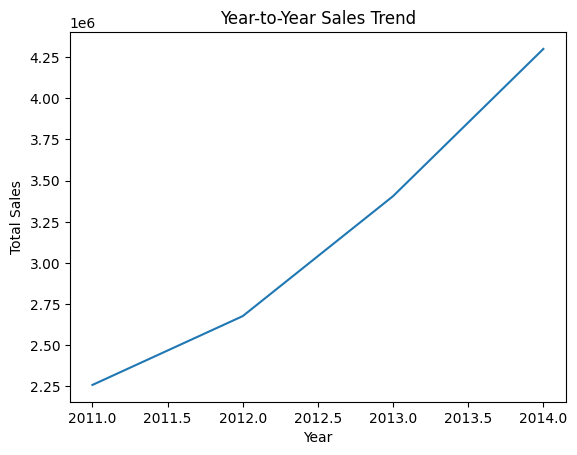

In [56]:
yearly_Sales = df.groupby('Year')['Sales'].sum()

plt.plot(yearly_Sales.index, yearly_Sales.values)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Year-to-Year Sales Trend')
plt.show()

<Figure size 800x500 with 0 Axes>

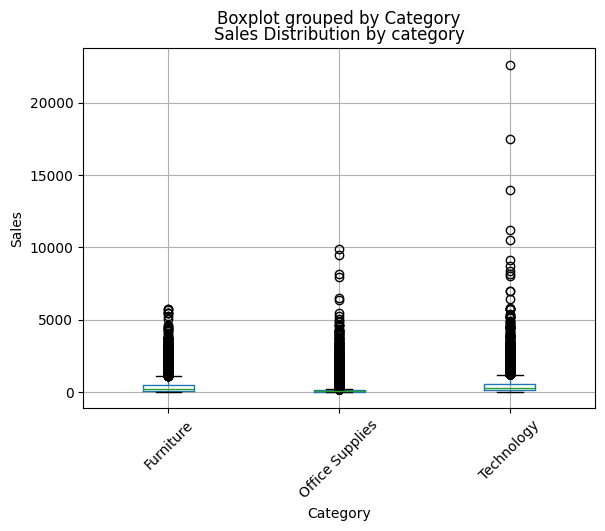

In [59]:
plt.figure(figsize=(8, 5))
df.boxplot(column='Sales', by='Category')
plt.title('Sales Distribution by category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

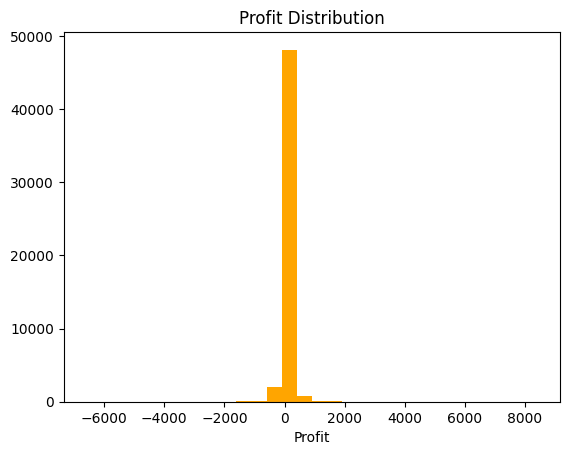

In [62]:
plt.hist(df['Profit'], bins=30, color='Orange')
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.show()

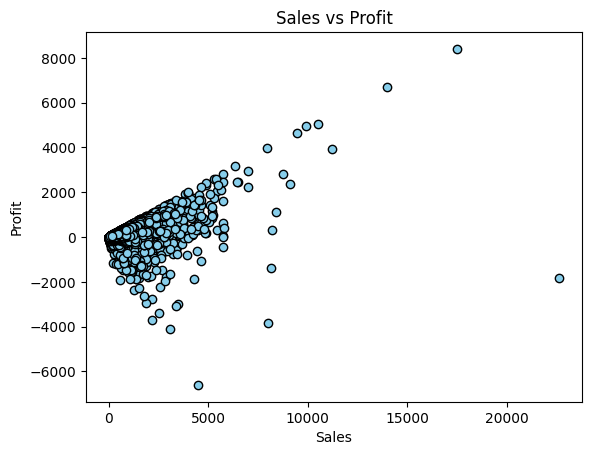

In [65]:
plt.scatter(df['Sales'], df['Profit'], color='skyblue', edgecolor='black')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.title('Sales vs Profit')
plt.show()

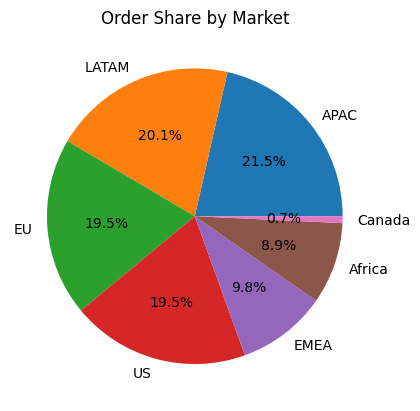

In [66]:
market_share = df['Market'].value_counts()
plt.pie(market_share, labels=market_share.index, autopct='%1.1f%%')
plt.title("Order Share by Market")
plt.show()

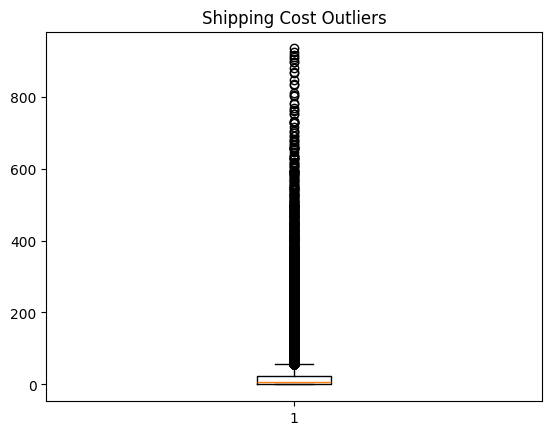

In [67]:
plt.boxplot(df['Shipping.Cost'])
plt.title("Shipping Cost Outliers")
plt.show()

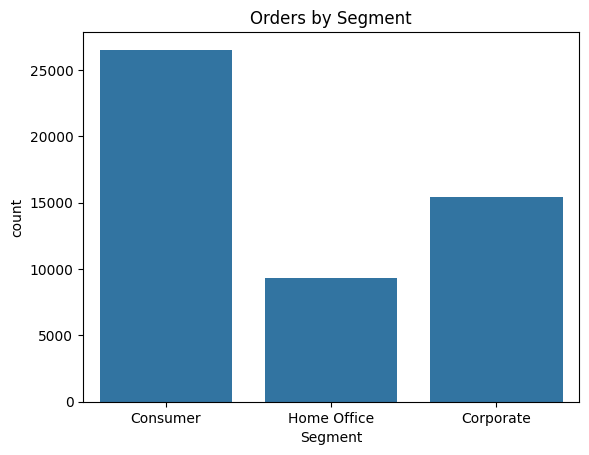

In [70]:
sns.countplot(data=df, x='Segment')
plt.title("Orders by Segment")
plt.show()

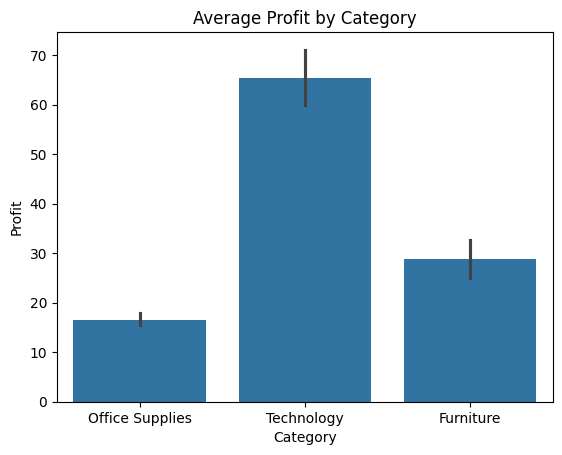

In [71]:
sns.barplot(data=df, x='Category', y='Profit')
plt.title("Average Profit by Category")
plt.show()

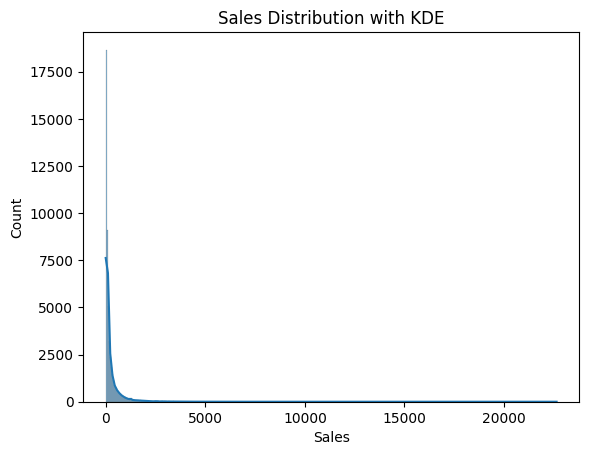

In [72]:
sns.histplot(df['Sales'], kde=True)
plt.title("Sales Distribution with KDE")
plt.show()

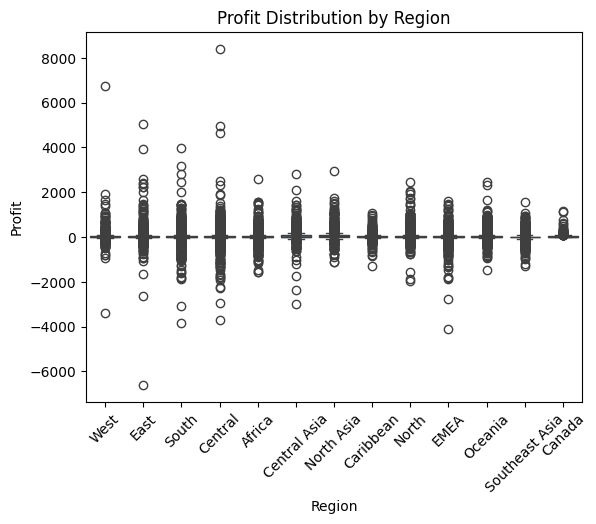

In [74]:
sns.boxplot(data=df, x='Region', y='Profit')
plt.title("Profit Distribution by Region")
plt.xticks(rotation=45)
plt.show()

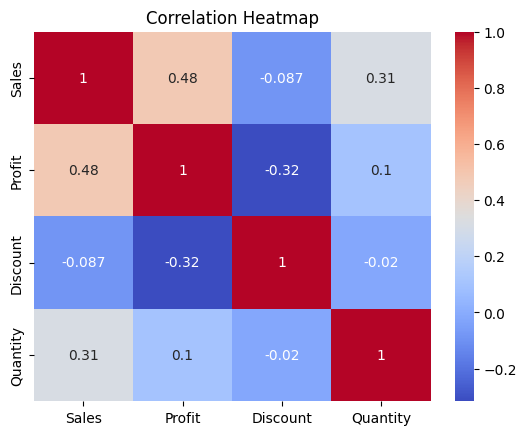

In [75]:
corr = df[['Sales', 'Profit', 'Discount', 'Quantity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

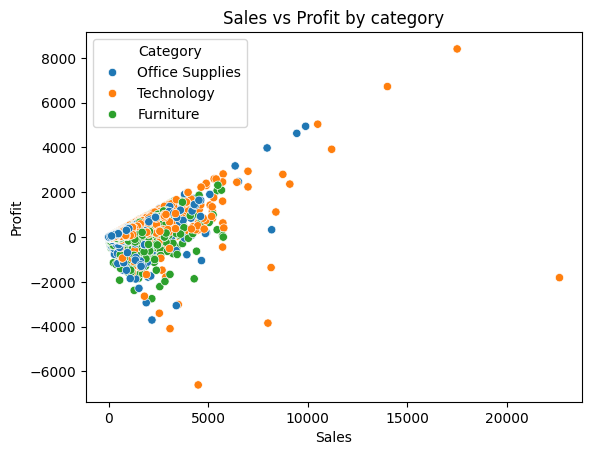

In [77]:
sns.scatterplot(data=df, x='Sales', y='Profit', hue='Category')
plt.title("Sales vs Profit by category")
plt.show()

In [85]:
yearly_sales = df.groupby('Year')['Sales'].sum().reset_index()
fig = px.line(
    yearly_sales,
    x='Year',
    y='Sales',
    title='Yearly Sales Trend'
)
fig.show()

In [87]:
fig = px.bar(df.groupby('Category')['Sales'].sum().reset_index(),
            x='Category', y='Sales', title='Sales by Category')
fig.show()

In [93]:
fig = px.scatter(df, x='Sales', y='Profit', color='Segment',
                title="Profit vs Sales by Segment")
fig.show()

In [95]:
fig = px.treemap(df, path=['Market', 'Region', 'Category'], values='Sales',
                title='Market -> Region -> Category Sales Breakdown')
fig.show()

In [96]:
corr = df[['Sales', 'Profit', 'Discount', 'Quantity']].corr()

fig = px.imshow(corr, text_auto=True, title='Correlation Heatmap')
fig.show()

In [98]:
fig = px.box(df, x='Ship.Mode', y='Shipping.Cost',
            title='Shipping Cost Boxplot by Ship Mode')
fig.show()